In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


project_root = Path('..').resolve()
sys.path.insert(0, str(project_root / 'src'))


sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print(f" Project Root: {project_root}")

 Project Root: /app


## 1. Wczytanie i Przygotowanie Danych

In [2]:

data_processed = project_root / 'data' / 'processed'
models_dir = project_root / 'models'
test_path = data_processed / 'test_features.csv'
model_path = models_dir / 'knn_model.pkl'

if test_path.exists():
    test_df = pd.read_csv(test_path)
    print(f" Wczytano dane testowe: {test_df.shape}")
else:
    print(" Brak pliku test_features.csv!")

y_test = test_df['genre']

# Przygotowanie cech (analogicznie do train_knn.py)
X_test_raw = test_df.drop(['genre', 'filename'], axis=1, errors='ignore')

# KLUCZOWY KROK (analogicznie do ml_pipeline.py):
# Wrapper GenericScikitLearner w metodzie predict() filtruje dane:
# X_processed = X.select_dtypes(include=[np.number])
# Musimy to powtórzyć, bo wczytany model to czysty Pipeline.
X_test = X_test_raw.select_dtypes(include=[np.number])

print(f" Dane gotowe do predykcji: {X_test.shape} (tylko kolumny numeryczne)")
genres = sorted(y_test.unique())

 Wczytano dane testowe: (200, 46)
 Dane gotowe do predykcji: (200, 43) (tylko kolumny numeryczne)


## 2. Predykcja Modelu

In [3]:
if model_path.exists():
    # Wczytanie modelu (to jest obiekt sklearn.pipeline.Pipeline)
    model = joblib.load(model_path)
    print(f" Model wczytany: {type(model)}")
    
    # Wykonanie predykcji na przygotowanych danych
    print(" Obliczanie predykcji...")
    try:
        y_pred = model.predict(X_test)
        print(" Predykcja zakończona sukcesem.")
    except Exception as e:
        print(f" Błąd predykcji: {e}")
else:
    print(" Nie znaleziono pliku modelu (knn_model.pkl)")

 Model wczytany: <class 'sklearn.pipeline.Pipeline'>
 Obliczanie predykcji...
 Predykcja zakończona sukcesem.


## 3. Ewaluacja i Wizualizacja

In [4]:
accuracy = accuracy_score(y_test, y_pred)
print(f" Accuracy: {accuracy:.2%}\n")
print(classification_report(y_test, y_pred, target_names=genres))

 Accuracy: 60.00%

              precision    recall  f1-score   support

       blues       0.68      0.65      0.67        20
   classical       0.90      0.90      0.90        20
     country       0.45      0.45      0.45        20
       disco       0.47      0.45      0.46        20
      hiphop       0.56      0.50      0.53        20
        jazz       0.61      0.85      0.71        20
       metal       0.64      0.70      0.67        20
         pop       0.56      0.75      0.64        20
      reggae       0.56      0.50      0.53        20
        rock       0.56      0.25      0.34        20

    accuracy                           0.60       200
   macro avg       0.60      0.60      0.59       200
weighted avg       0.60      0.60      0.59       200



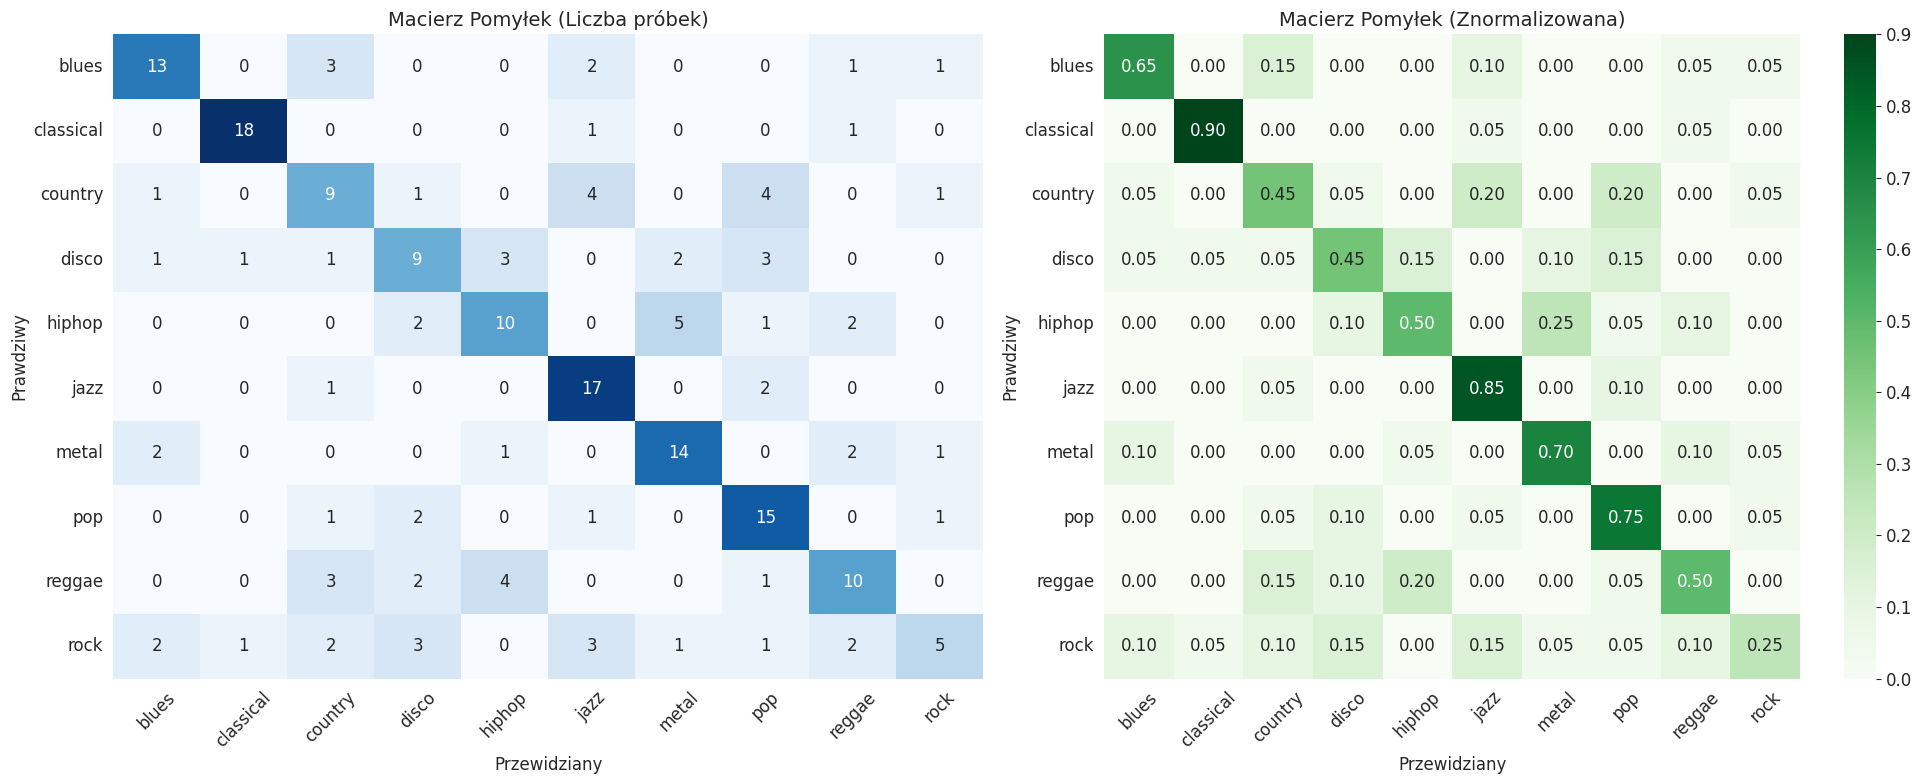

In [5]:
#Macierz Pomyłek (Liczebność + Normalizacja)
cm = confusion_matrix(y_test, y_pred, labels=genres)

#  dwie mapy ciepła obok siebie
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 1. Liczebność
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=genres, yticklabels=genres, ax=axes[0])
axes[0].set_title('Macierz Pomyłek (Liczba próbek)', fontsize=14)
axes[0].set_xlabel('Przewidziany')
axes[0].set_ylabel('Prawdziwy')
axes[0].tick_params(axis='x', rotation=45)

# 2. Normalizacja (Procenty w wierszach)
# Dzielimy każdy wiersz przez sumę wiersza (prawdziwą liczbę próbek w klasie)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', cbar=True,
            xticklabels=genres, yticklabels=genres, ax=axes[1])
axes[1].set_title('Macierz Pomyłek (Znormalizowana)', fontsize=14)
axes[1].set_xlabel('Przewidziany')
axes[1].set_ylabel('Prawdziwy')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

/tmp/ipykernel_23/3820460189.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_pairs, x='Count',


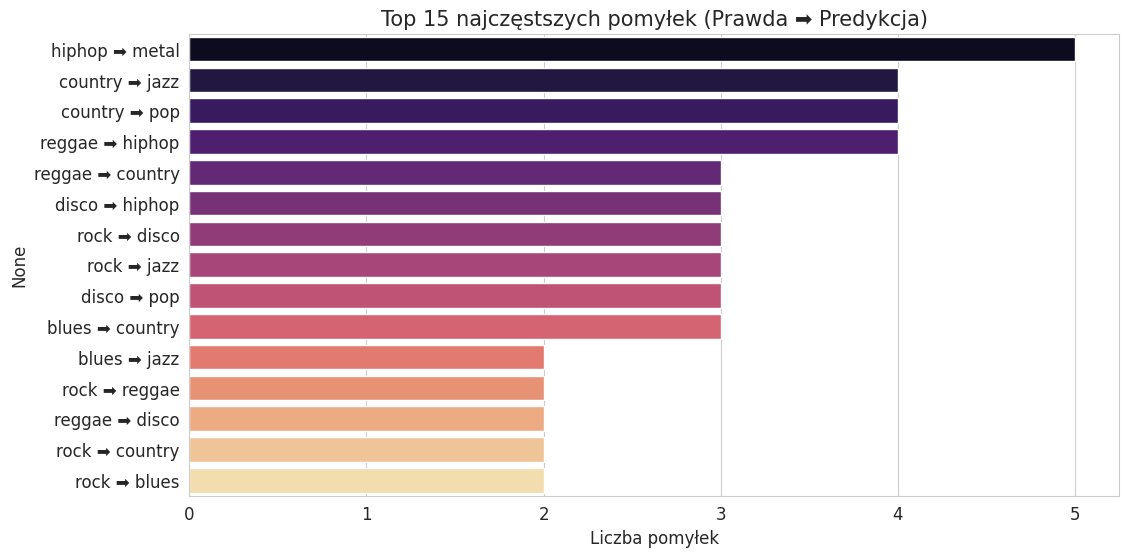

In [6]:
# Wizualizacja: Analiza Błędów (Które pary mylą się najczęściej?)
results = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
errors = results[results['True'] != results['Predicted']]

# Zliczanie par błędów
error_pairs = errors.groupby(['True', 'Predicted']).size().reset_index(name='Count')
error_pairs = error_pairs.sort_values('Count', ascending=False).head(15)

# Wykres
plt.figure(figsize=(12, 6))
sns.barplot(data=error_pairs, x='Count', 
            y=error_pairs.apply(lambda x: f"{x['True']} ➡️ {x['Predicted']}", axis=1),
            palette='magma')
plt.title('Top 15 najczęstszych pomyłek (Prawda ➡️ Predykcja)', fontsize=15)
plt.xlabel('Liczba pomyłek')
plt.show()